# Bigram Language Model

### Counting Probabalistic model:
First we will use the data set to determine the probability that any letter will follow any other. 

That means counting every pair of letters for how many times it appears 

> i.e. how many times is `a` followed by `a`, how many times is `a` followed by `b`, etc...

We can use those counts to construct a probability distribution and from the probability ditribution we can sample _new_ data.

> i.e. if we know `a` follows `a` 3% of the time, `b` follows `a` 8% of the time, ... , `z` follows `a` 1% of the time,  we can use that to guess a next letter, given any input letter.

In [ ]:
import torch # Pytorch

# loading dataset from .txt
words = open('names.txt', 'r').read().splitlines()

# make a set of all the unique characters in the dataset, '.' is used as a delimiter token
char_set = sorted(list(set('.'.join(words))))
# make an encoding and decoding dictionary to translate char -> int and int -> char
char_encode = {ch:i for i,ch in enumerate(char_set)}
char_decode = {i:ch for ch,i in char_encode.items()}
print(char_encode)

Calculating probabilities of all character pairs:

In [ ]:
# counting all occurances of a character following another
N = torch.zeros((len(char_encode),len(char_decode)), dtype=torch.int32) # 27x27 tensor
for w in words:
    chs = ['.'] + list(w) + ['.'] # make start and end of words explicit
    for ch1, ch2 in zip(chs, chs[1:]): 
        ix1 = char_encode[ch1]
        ix2 = char_encode[ch2]
        N[ix1, ix2] += 1

# convert counts into probabilities
P = (N+1).float() # smoothing with +1 avoids divide by zero errors
P /= P.sum(dim=1, keepdims=True) # divide each element by the sum of its column

# sanity check
print(f"likelihood of a character being the first character:")
for i, p in enumerate(P[0]): print(f"{(char_decode[i],'{0:.4f}'.format(p.item()))}") 

Now we can use this to generate new names:

In [ ]:
# generate 20 sample names
g = torch.Generator().manual_seed(2147483647) # defining a specific random number generator
for i in range(10):
    out = []
    ix = 0 # initial character is '.'
    while True:
        w = P[ix] # select the probabilities of each possible next character
        ix = torch.multinomial(w, 1, replacement=True, generator=g).item() # sample
        if ix == 0:
            break
        out.append(char_decode[ix])
    print(''.join(out))

Next we have to calculate the loss of the model, here thats the mean negative log likelihood:

In [ ]:
negative_log_likelihood = 0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.'] # make start and end of words explicit for more info
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = char_encode[ch1]
        ix2 = char_encode[ch2]
        prob = P[ix1,ix2]
        negative_log_likelihood -= torch.log(prob)
        n+=1
        # print(f"{ch1}{ch2}: {prob:.4f} {torch.log(prob):.4f}")

print(f"number of samples: {n}")
print(f"negative log likelihood: {negative_log_likelihood}")
print(f"mean negative log likelihood: {negative_log_likelihood/n}")

### Neural Network Model

To build a dataset, we need to build up an `X` and `y` array where `y = Neural_Network(X)`. 

Here that means our input is an array of every first character in a pair of characters.
> i.e. data: ['.anna.', '.olivia.', '.ava.']
>
> (x: '.', y: 'a')
>
> (x: 'a', y: 'n')
> 
> (x: 'n', y: 'n')
>
> (x: 'n', y: 'a')
>
> (x: 'a', y: '.')
>
> (x: '.', y: 'o')
>
> ...

that means every character except the very last charcter, which has no character following it. Our output will be the same, every character, except the very first one, which has no other character before it.
> x: ['.', 'a', 'n', 'n', 'a', '.', 'o', ...]
>
> y: ['a', 'n', 'n', 'a', '.', 'o', 'l', ...]

In [ ]:
# Create the training set of all the bigrams
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = char_encode[ch1]
        ix2 = char_encode[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.nelement()
print('number of training examples: ', num)
# print([x for x in zip(xs[:10].numpy(), ys[:10].numpy())])

g = torch.Generator().manual_seed(2147483647)
W = torch.zeros((27, 27), requires_grad=True)# 27 neurons
#W = torch.randn((27, 27), generator=g, requires_grad=True)  

- We can feed out inputs into the model using one hot encoding, this turns an integer, i, into a 1xN array of 0's where the i'th index is 1. 
> [5] -> [0,0,0,0,0,1,0,0,0,...]
> [2] -> [0,0,1,0,0,0,0,0,0,...]

- Matrix multiplication is used to evaluate all the neurons in parallel
> `x @ W` -> `dot(x1,w1), dot(x2,w2), ... , dot(xn,wn)`

- Soft-max is used to convert the output from 27 positive and negative values into 27 probabilities, that all sum to 1
> potential outputs:
>
> x = [-4.32, 3.78, -2.38, -7.82, 1.30, -1.43] 
> $$softmax(x) = exp(x) / \sum(exp(x))$$
> [.00028, .91606, .01935, .000008, .0076714, .00500]
>
> sum([.00028, .91606, .00193, .00000, .07671, .00500]) = 1.00000

- The loss used is the mean negative log likelihood
> take the input data x and check how likely it is to predict the true next value, an amazing model would have near 100% confidence in its next guess, but we wont achieve anything near that with these approaches
>
> i.e. '.anna.' 
>
> '.' -> probability('a') = 17%
> 
> 'a' -> probability('n') = 8% 
>
> Do this for every input used on the model:    x<sub>i</sub> -> p<sub>i</sub>
> $$ {\sum(log(-p_i)) \over i} $$


In [ ]:
import torch.nn.functional as F

for k in range(500):

    # forward pass
    x_enc = F.one_hot(xs, num_classes=27).float() # one hot encoding
    logits = x_enc @ W # equivalent to log(counts) from the probabilistic model
    counts = logits.exp() 
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(xs.nelement()), ys].log().mean() # + (W**2).mean()
    print(loss.item())

    #backward pass
    W.grad = None # set the gradient to zero, but more performantly than = 0
    loss.backward()

    # update
    W.data += -50 * W.grad

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while True:

        x_enc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = x_enc @ W # log counts
        counts = logits.exp()
        w = counts / counts.sum(1, keepdims=True)

        ix = torch.multinomial(w, 1, replacement=True, generator=None).item()
        
        if ix == 0:
            break
        else: 
            out.append(char_decode[ix])

    print(''.join(out))

In [5]:
import torch
from language_models import BigramLanguageModel

words = open('names.txt', 'r').read().splitlines()

# make a set of all the unique characters in the dataset, '.' is used as a delimiter token
char_set = sorted(list(set('.'.join(words))))
# make an encoding and decoding dictionary to translate char -> int and int -> char
char_encode = {ch:i for i,ch in enumerate(char_set)}
char_decode = {i:ch for ch,i in char_encode.items()}

# Create the training set of all the bigrams
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = char_encode[ch1]
        ix2 = char_encode[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.nelement()
print('number of training examples: ', num)

model = BigramLanguageModel(xs,ys, decode=char_decode)
w, loss = model.train(500,50)
print(f"Loss: {loss:.4f}")

g = torch.Generator().manual_seed(2147483647)
model.generate(generator=g,verbose=True)

number of training examples:  228146
Loss: 2.4568
mor.axx.minaymoryles.kondlaisah.anchshizarie.odaren.iaddash.h.jhinatien.egushk.ga.t.a.jayn.ilemannar
maenien.be.f.akiinela.trttanakeroruceyaaxatona.lamoynayrkhadengin.torrederahmokallovyllobrpin.a.wai.
kn.jaieendenelele.kianu.eryly.zeeieil.kayvirgiynenn.r.t.rja.kronanurolin.din.elfr.dikie.s.elarieiave
jochin.jon.eythann.janianaeri.ble.ckiree.l.adgenoena.naisaryan.sialaitalyee.cena.lisarr.bizyngor.eve
a.kahish.tovih.al.an.amulileron.jar.ran.erelezio.ahistorarieneibrodaiazindiah.lssthmi.havanajey.g.pe
e.gre.ga.taashellestroulyirrydany.rrartar.liala.leleanaiai.manni.aumobh.i.k.mirvekliyiy.n.alinaiyn.m
mikelana.rskelier.men.o.br.vihilun.lis.belioeyoniussadqunila.chi.e.dar.stlaelivinteyast.an.ionn.krat
mran.usorran.h.r.my.rykenayl.kyalileyl.xia.keohanannon.fon.aya.le.kya.khie.alo.ton.phaghrie.b.ryarem
ela.keelan.jeranachmisamairona.jalia.jjoaicaveeyme.anen.m.ely.kie.ladeigsira.habllara.a.thieirebraen
aneichxiedhikhaisllysalaranniry.achann.da

In [6]:
import torch
from language_models import BigramLanguageModel

shakespear = list(open('shakespear.txt', 'r').read())

char_set = sorted(list(set(''.join(shakespear))))

char_encode = {ch:i for i,ch in enumerate(char_set)}
char_decode = {i:ch for ch,i in char_encode.items()}

xs, ys = [], []
for i in range(len(shakespear)-1):
    idx1 = char_encode[shakespear[i]]
    idx2 = char_encode[shakespear[i+1]]
    xs.append(idx1)
    ys.append(idx2)
    # print(char_encode[shakespear[i]], char_encode[shakespear[i+1]])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.nelement()
print('number of training examples: ', num)

model = BigramLanguageModel(xs,ys, num_classes=len(char_decode), decode=char_decode)
w, loss = model.train(10000,70, batch_size=256)

print(f"Loss: {loss:.4f}")

g = torch.Generator().manual_seed(2147483647)
model.generate(generator=g, num=1, max_length=10000, verbose=True);

number of training examples:  99992
Loss: 2.4169
OUS:
Wo siseshouthep.
Thel lod caredoout the s d:
MI che the'd sothor; f-byoou il w aleayo.
I oflonotalllel be h aninghe Ifous opiousow.
s cr, seake mutletourallllll, soun.
TO:
TRDINowrelodepot.

Y k oule ke seareard OLS:
d
Butho y!
DELO, futhooutirgofo vathe musapowitarl, pomarer d mom t fe the fomer mot lor futheit
HESe s, thake bemounDAT:
Brast s,
SI ully s thealer my'd d on poucou bexthisie we cofathe vethe ar ar RLonfinoun, br t s fond you,
Catothenfed herod l yothe inequthou ker ooneve INI bend he w,
The; mussovesenowheew tn tofo'se m blbin!
I e,
O:
To Goouck l m
Nouthenethy s'anelintheisoore safourear?

OHe s bs yoourse otoaje, s yorlthof thelil ckie be s tot-SHaveitawato Thanndilit thr s youst.

D t sw tred lth my meapur y,
ARLUEMarers, hngacr ble my Birom aro yot seamere,


Tofone l ard l pearofopeathod fathe:
F:
K:
Hen lchramyor INYe s ghy mon ogeandothe in, s s be whindan, che she owhe oureanothyofe t sthowad oren e be rd.
De 

In [2]:
import torch
from language_models import TrigramLanguageModel

shakespear = list(open('shakespear.txt', 'r').read())

char_set = sorted(list(set(''.join(shakespear))))

char_encode = {ch:i for i,ch in enumerate(char_set)}
char_decode = {i:ch for ch,i in char_encode.items()}

xs, ys = [], []
for i in range(len(shakespear)-2):
    idx1 = char_encode[shakespear[i]]
    idx2 = char_encode[shakespear[i+1]]
    idx_out = char_encode[shakespear[i+2]]
    xs.append([idx1,idx2])
    ys.append(idx_out)
    # print([idx1, idx2], idx_out)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.shape[0]
print('number of training examples: ', num)

model = TrigramLanguageModel(xs,ys, num_classes=len(char_decode), decode=char_decode)
w, loss = model.train(10000, 10, verbose=False, batch_size=512)

print(f"Loss: {loss:.4f}")

g = torch.Generator().manual_seed(2147483647)
output = model.generate(generator=g, num=1, max_length=10000, verbose=True);

number of training examples:  99991
Loss: 2.2550
Por avid, shthout, tanis.

Go ge
Thet.
Werin that ohaik,
Whancemme.

For gut t hagr ale, thee:
Cat thalle s am hablomeed Ineto me, tort ful weseed of twiousele poree tiss'd thest ghnsty to tore cat hast hand singhirea mo nt
Fover yould mandswithetoren! If tie nound, oukef eniok.

ASSDRK:
Ahalld ght is irl;
VIA: wheno kefoll for bon eroul bo ced st on thes swOF op:
ESTENTI Mall'Tims ou divirise hop ancenor towef an an Why poornce,
TOR:
Adame.'
Ta gotorlathell fro.

Bzend,
Hastounke
I's me, y'l thaill,
GL:
ARUS:
Thithithtenst;
It to to teck of mand nom ifearsicas; I Se m oust hout y th mire-sighithed sh'slland teeen, I way, shou nove heis yourtis comend becr fald.

him, my sugs to bo hiss lo thome virnque hat ow tred:
Wh ow mineve
sig.

Saiondgre'd, afte phast Eell aher wis por ithe cast she ke noch seast ood tit malll, Gike garno hall furd I or pandw, th se me: no deaing th agren:
That fo nom nus cot ondenowran.

Prout amed.

CK:
Foreall 

In [112]:
import torch
from language_models import NgramLanguageModel

N=4
shakespear = list(open('shakespear.txt', 'r').read())

char_set = sorted(list(set(''.join(shakespear))))

char_encode = {ch:i for i,ch in enumerate(char_set)}
char_decode = {i:ch for ch,i in char_encode.items()}

xs, ys = [], []

count = 0

xs, ys = [], []
for i in range(len(shakespear)-N+1):
    idx_in = [char_encode[token] for token in shakespear[i:i+N-1]]
    idx_out = char_encode[shakespear[i+N-1]]
    xs.append(idx_in)
    ys.append(idx_out)
    # print(''.join(char_decode[i] for i in idx_in), '-->', char_decode[idx_out])
    count += 1


xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f"training model with {xs.shape[1]+1}-gram model")
print(f"size of input vector: {xs.shape[1]}\nnumber of input training examples: {xs.shape[0]}")
    

model = NgramLanguageModel(xs,ys, N=N, num_classes=len(char_decode), decode=char_decode)
w, loss = model.train(3000, 1, verbose=True, batch_size=512)

print(f"Loss: {loss:.4f}")

g = torch.Generator().manual_seed(2147483647)
output = model.generate(generator=g, num=1, max_length=2000, verbose=True);

training model with 4-gram model
size of input vector: 3
number of input training examples: 99990
Epoch 0. Loss: 4.1271
Epoch 1. Loss: 4.1143
Epoch 2. Loss: 4.1021
Epoch 3. Loss: 4.0877
Epoch 4. Loss: 4.0724
Epoch 5. Loss: 4.0603
Epoch 6. Loss: 4.0488
Epoch 7. Loss: 4.0346
Epoch 8. Loss: 4.0176
Epoch 9. Loss: 3.9989
Epoch 10. Loss: 3.9978
Epoch 11. Loss: 3.9765
Epoch 12. Loss: 3.9678
Epoch 13. Loss: 3.9760
Epoch 14. Loss: 3.9437
Epoch 15. Loss: 3.9449
Epoch 16. Loss: 3.9230
Epoch 17. Loss: 3.9090
Epoch 18. Loss: 3.9125
Epoch 19. Loss: 3.8831
Epoch 20. Loss: 3.8811
Epoch 21. Loss: 3.8766
Epoch 22. Loss: 3.8555
Epoch 23. Loss: 3.8421
Epoch 24. Loss: 3.8444
Epoch 25. Loss: 3.8117
Epoch 26. Loss: 3.7957
Epoch 27. Loss: 3.7968
Epoch 28. Loss: 3.7862
Epoch 29. Loss: 3.7621
Epoch 30. Loss: 3.7463
Epoch 31. Loss: 3.7372
Epoch 32. Loss: 3.7435
Epoch 33. Loss: 3.7480
Epoch 34. Loss: 3.7154
Epoch 35. Loss: 3.7264
Epoch 36. Loss: 3.7280
Epoch 37. Loss: 3.6975
Epoch 38. Loss: 3.6847
Epoch 39. Loss:

In [188]:
import torch.nn.functional as F

emb_size = 2
block_size = N-1
hidden_neurons = 100
batch_size = 512

g = torch.Generator().manual_seed(2147483647)
C = torch.randn([len(char_decode),emb_size], generator=g)
W1 = torch.randn((emb_size*block_size,hidden_neurons), generator=g)
b1 = torch.randn(hidden_neurons, generator=g)
W2 = torch.randn((hidden_neurons,len(char_decode)), generator=g)
b2 = torch.randn(len(char_decode), generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

str_data = "asdffqedwebgwefrgetbgrewrfeq"
n1 = int(0.8*len(str_data))
n2 = int(0.9*len(str_data))
Xtr, Ytr = build_dataset(str_data[:n1])
Xdev, Ydev = build_dataset(str_data[n1:n2])
Xte, Yte = build_dataset(str_data[n2:])


7086


28

In [178]:
# lre = torch.linspace(-3,0,1000) # learning rate exponent
# lrs = 10**lre # learning rates

# lri = []
# lossi = []

for i in range(10000):

    #batch input and output data
    idxs = torch.randint(low=0,high=xs.shape[0],size=(batch_size,),generator=g)
    
    # forward pass
    emb = C[xs[idxs]]
    h_layer = torch.tanh(emb.view(-1,emb_size*block_size) @ W1 + b1)
    logits = h_layer @ W2 + b2
    loss = F.cross_entropy(logits, ys[idxs])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    # lr = lrs[i]
    for p in parameters:
        p.data += -0.01 * p.grad
    
    # # track stats
    # lri.append(lr)
    # lossi.append(loss.item())

print(loss.item())


2.1676559448242188


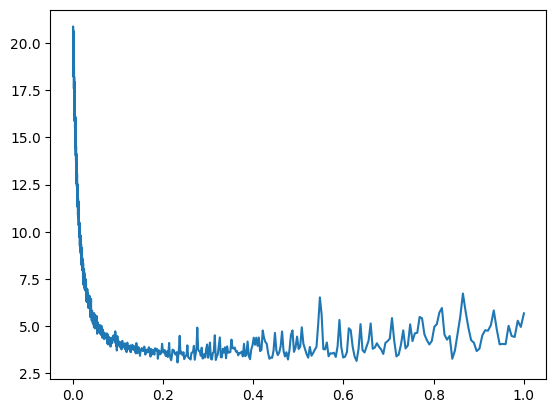

In [170]:
import matplotlib.pyplot as plt
plt.plot(lri, lossi)

In [138]:
# training splot, dev/validation split, test split
# 80%, 10%, 10%


2.6436233520507812